Automatic pdb calling has been turned ON
3724


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


3693
3664
3638
3611
3582
3557
3532
3491
3466
3457
3423
3396
3372
3332
3299
3273
3234
3209
3184
3159
3134
3109
3084
3051
3010
2989
2960
2931
2906
2865
2844
2815
2790
2761
2720
2691
2666
2645
2616
2575
2546
2521
2480
2451
2426
2385
2356
2331
2286
2261
2236
2207
2168
2143
2118
2093
2068
2032
2007
1995
1954
1929
1904
1870
1845
1837
1829
1804
1791
1765
1756
1737
1718
1692
1665
1645
1619
1593
1565
1557
1524
1498
1493
1472
1443
1428
1393
1368
1363
1361
1326
1301
1276
1272
1237
1212
1207
1182
1157


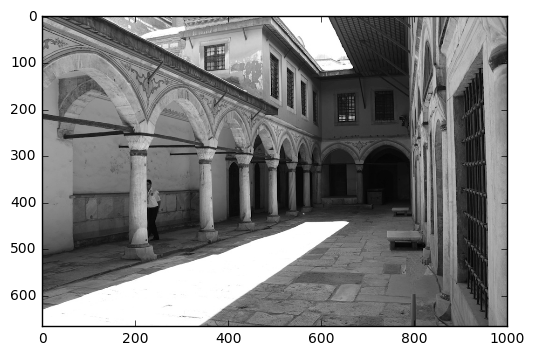

1141
1116
1091
1080
1035
1010
985
955
930
907
899
894
873
868
843
818
793
777
773
764
759
734
719
674
649
624
619
594
569
544
519
504
459
434
407
383
360
328
303
288
263
238
223
208
183
168
163
154
129
99
74
47
32
23
21
6


TypeError: %d format: a number is required, not str

> <ipython-input-6-56a2e8647534>(166)objectremoval()
    164     plt.imshow(new_img,'gray')
    165     plt.title('Sythesized image for %s with windowsize %d' %(filename,win_size))
--> 166     plt.savefig('Removal%s_size_%d_mask%d.png' %(filename,win_size,maskname[-1]))
    167     plt.show()
    168 

ipdb> plt.savefig('Removal%s_size_%d_mask%s.png' %(filename,win_size,maskname[-1]))
ipdb> plt.show()


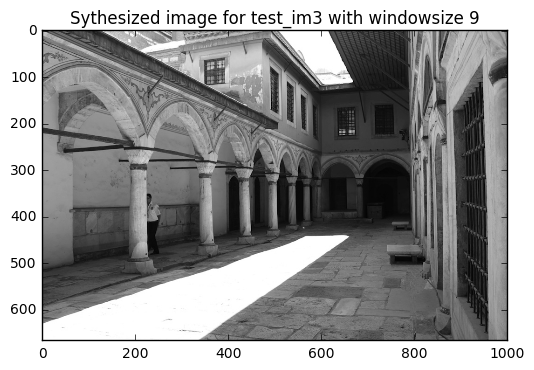

ipdb> q


In [6]:
import numpy as np
import scipy
from skimage import morphology, io, img_as_float, color
import matplotlib.pyplot as plt
import os
import sys
import pdb
import time
from sklearn import feature_extraction as sfe
sys.path.append("/Users/xiaolihe/Documents/Computer-Vision-534/hw2")
%pdb on

def Getboundarypoints(filled_status):
    subs_image = morphology.dilation(filled_status) - filled_status
    #     pdb.set_trace()
    [row_idxs, col_idxs] = np.where(subs_image != 0)
    # random permutation
    randidx = np.random.permutation(len(row_idxs))
    locs = [(row_idxs[idx],col_idxs[idx]) for idx in randidx]
    return locs

# get confidence value in the template window, and its filled status
def GetNeighborhoodWindow(ridx, colidx, new_img, grad_mag, conf,filled_status, win_size):
    half_win_size = win_size / 2
    row_range = range(ridx - half_win_size, ridx + half_win_size + 1)
    col_range = range(colidx - half_win_size, colidx + half_win_size + 1)
    template_img = np.zeros((win_size, win_size))
    template_grad = np.zeros((win_size, win_size))
    template_conf = np.zeros((win_size, win_size))
    template_filled_status = np.ones((win_size, win_size)) == False
    # row,column range in the img2bfilled
    if row_range[0]>=0 and col_range[0]>=0 and row_range[-1] < conf.shape[0] and col_range[-1] < conf.shape[1]:
        template_img = new_img[row_range[0]:row_range[-1]+1,col_range[0]:col_range[-1]+1]
        template_conf = conf[row_range[0]:row_range[-1]+1,col_range[0]:col_range[-1]+1]
        template_grad = grad_mag[row_range[0]:row_range[-1]+1,col_range[0]:col_range[-1]+1]
        template_filled_status = filled_status[row_range[0]:row_range[-1]+1,col_range[0]:col_range[-1]+1]
    else:
        minr_img2f = max(0, ridx - half_win_size)
        maxr_img2f = min(conf.shape[0], ridx + half_win_size + 1)
        minc_img2f = max(0, colidx - half_win_size)
        maxc_img2f = min(conf.shape[1], colidx + half_win_size + 1)
        template_img[minr_img2f-ridx+half_win_size:maxr_img2f-ridx+half_win_size,
        minc_img2f-colidx+half_win_size:maxc_img2f-colidx+half_win_size] = new_img[minr_img2f:maxr_img2f, minc_img2f:maxc_img2f]
        template_conf[minr_img2f-ridx+half_win_size:maxr_img2f-ridx+half_win_size,
        minc_img2f-colidx+half_win_size:maxc_img2f-colidx+half_win_size] = conf[minr_img2f:maxr_img2f, minc_img2f:maxc_img2f]
        template_grad[minr_img2f-ridx+half_win_size:maxr_img2f-ridx+half_win_size,
        minc_img2f-colidx+half_win_size:maxc_img2f-colidx+half_win_size] = grad_mag[minr_img2f:maxr_img2f, minc_img2f:maxc_img2f]
        template_filled_status[minr_img2f-ridx+half_win_size:maxr_img2f-ridx+half_win_size,
        minc_img2f-colidx+half_win_size:maxc_img2f-colidx+half_win_size] = filled_status[minr_img2f:maxr_img2f, minc_img2f:maxc_img2f]
    return template_img, template_grad, template_conf, template_filled_status


## Find Matches, return locations, corresponding ssd (in 1d), and corresponding pixel value
def FindMatches(template, sample_img, source_mask, ValidMask, win_size):
    Sigma = win_size / 6.4
    GaussMask = gkern(win_size, Sigma)
    mask_raw = np.multiply(ValidMask, GaussMask)
    mask_normalized = mask_raw / mask_raw.sum()
    patches_list0 = sfe.image.extract_patches_2d(sample_img, (win_size,win_size))# array, shape = (n_patches, patch_heidth)
    mask_list = sfe.image.extract_patches_2d(source_mask, (win_size,win_size))# array, shape = (n_patches, patch_heidth)
    patches_list = patches_list0[np.sum(mask_list,(1,2))==win_size*win_size]
    dist_filter = (patches_list - template)**2*mask_normalized
    SSD = np.asarray([d.sum() for d in dist_filter])
    res_loc_1d, = np.where(SSD == SSD.min())
    # pdb.set_trace()
    return patches_list[res_loc_1d][0]

def gkern(size, sigma=3.0, center=None):
	""" Make a square gaussian kernel.

    size is the length of a side of the square
    sigma is standard deviation
    can be thought of as an effective radius.
    """

	x = np.arange(0, size, 1, float)
	y = x[:, np.newaxis]

	if center is None:
		x0 = y0 = size // 2
	else:
		x0 = center[0]
		y0 = center[1]
	raw_res = 1/(2*np.pi*sigma**2)*np.exp(-((x - x0) ** 2 + (y - y0) ** 2) / (2*sigma ** 2))
	return raw_res/raw_res.sum()

# filled in target region with the best match, and update correspoinding target_mask, source_mask, confidence value
def filledin(ploc, win_size, new_img, conf, target_mask, source_mask, bestmactchpatch):
    half_win_size = win_size/2
    row_range = range(ploc[0] - half_win_size, ploc[0] + half_win_size + 1)
    col_range = range(ploc[1] - half_win_size, ploc[1] + half_win_size + 1)
    for r in row_range:
        for c in col_range:
            if r >=0 and c>=0 and r<new_img.shape[0] and c< new_img.shape[1]:
                if target_mask[r,c]:
                    new_img[r,c] = bestmactchpatch[r-ploc[0],c-ploc[1]]
                    target_mask[r,c] = False
                    source_mask[r,c] = True
                    conf[r,c] = conf[r-ploc[0], c-ploc[1]]


def objectremoval(filename, filetype, maskname, win_size = 9):
    # read sample image
    t = time.time()
    img_sample0 = io.imread(os.getcwd() + '/Documents/Computer-Vision-534/hw2/Assignment-II-images/' + filename + filetype)
#     img_sample0 = io.imread(os.getcwd() + '/Assignment-II-images/' + filename + filetype)
    img_sample0 = color.rgb2gray(img_sample0) # rgb to gray level
    img = img_as_float(img_sample0) # convert image to 0-1 values
    new_img = np.copy(img)
    alpha = 1
    ## load mask
    mask = img_as_float(color.rgb2gray(io.imread(os.getcwd() + '/Documents/Computer-Vision-534/hw2/Assignment-II-images/' + maskname + '.jpg')))
#     mask = img_as_float(color.rgb2gray(io.imread(os.getcwd() + '/Assignment-II-images/' + maskname + '.jpg')))
    mask = mask.astype('bool') # target region: 1;  else: 0
#     plt.imshow(mask,'gray')
#     plt.show()
    target_mask = mask
    source_mask = mask == False
    # P = C*D
    # initialize confidence term and data term
    conf = (source_mask).astype('double')
    D = (source_mask).astype('double')
    # print conf
    idx = 0
    while target_mask.any():
        print target_mask.sum()
        ## find pixels on the contour
        p_list = Getboundarypoints(np.logical_not(mask)) #(x,y) location
        grad_x, grad_y = np.gradient(img)
        grad_x = np.array(grad_x)
        grad_y = np.array(grad_y)
        grad_mag = np.sqrt(np.array(grad_x)**2 + np.array(grad_y)**2)
        Prior = []
        for point in p_list:
            ## Computing patch priorities
            template, template_gradient, template_c, template_filled_status = GetNeighborhoodWindow(point[0], point[1],new_img, grad_mag, conf, source_mask, win_size)
            # C (C(q) within template, and the area of the template)
            conf[point] = (template_c*template_filled_status).sum()/(win_size*win_size)
            # Data (max gradient, normal direction n_p within template)
            max_gradient = template_gradient.max()
            norm_p = [grad_x[point],grad_y[point]]
            norm_p = norm_p/np.linalg.norm(norm_p)
            norm_p = np.array([0,0]) if np.isnan(norm_p[0]) or np.isnan(norm_p[1]) else norm_p
            D[point] =  np.linalg.norm(max_gradient*norm_p)/alpha
            # priority
            # Prior[point]= conf[point]*D[point]
            Prior.append(conf[point]*D[point])
        ## Propagating texture and structure information
        # find max pirority patch
        Prior = np.array(Prior)
        priority_idx, = np.where(Prior == Prior.max())
        priority_ploc = p_list[priority_idx[np.random.randint(0, len(priority_idx))]]
        template_img, template_gradient, template_c, template_filled_status = GetNeighborhoodWindow(priority_ploc[0], priority_ploc[1],new_img, grad_mag, conf, source_mask, win_size)
        BestMatch_patch = FindMatches(template_img, new_img, source_mask, template_filled_status, win_size)
        # fill in the patch and Updating confidence values.
        filledin(priority_ploc, win_size,new_img, conf, target_mask, source_mask, BestMatch_patch)
        idx += 1
        if idx%100 == 0:
            plt.imshow(new_img,'gray')
            plt.show()
    elapsed = time.time() - t
    print 'Total runtime is ',elapsed
    plt.imshow(new_img,'gray')
    plt.title('Object removal for %s with windowsize %d (mask for %s)' %(filename,win_size,maskname))
    plt.savefig('Removal%s_size_%d_mask%s.png' %(filename,win_size,maskname[-1]))
    plt.show()

objectremoval('test_im3','.jpg','test_im3_mask3', win_size = 9)



